In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
from PIL import Image
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

2024-02-20 09:04:53.311170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 09:04:53.311254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 09:04:53.436533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_images = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train"
test_images = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test"

In [4]:
class_names = [filename for filename in os.listdir(train_images)]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
min_width = float('inf')
min_height = float('inf')

In [6]:
"""

for folders in os.listdir(train_images):
    train_folders = os.path.join(train_images, folders)
    for filename in os.listdir(train_folders):
        if filename.endswith(".jpg"):
            img_path = os.path.join(train_folders, filename)
            img = Image.open(img_path)
            width, height = img.size
            min_width = min(min_width, width)
            min_height = min(min_height, height)
            
for folders in os.listdir(test_images):
    test_folders = os.path.join(test_images, folders)
    for filename in os.listdir(test_folders):
        if filename.endswith(".jpg"):
            img_path = os.path.join(test_folders, filename)
            img = Image.open(img_path)
            width, height = img.size
            min_width = min(min_width, width)
            min_height = min(min_height, height)
            
print("Minimum width:", min_width)
print("Minimum height:", min_height)

"""

'\n\nfor folders in os.listdir(train_images):\n    train_folders = os.path.join(train_images, folders)\n    for filename in os.listdir(train_folders):\n        if filename.endswith(".jpg"):\n            img_path = os.path.join(train_folders, filename)\n            img = Image.open(img_path)\n            width, height = img.size\n            min_width = min(min_width, width)\n            min_height = min(min_height, height)\n            \nfor folders in os.listdir(test_images):\n    test_folders = os.path.join(test_images, folders)\n    for filename in os.listdir(test_folders):\n        if filename.endswith(".jpg"):\n            img_path = os.path.join(test_folders, filename)\n            img = Image.open(img_path)\n            width, height = img.size\n            min_width = min(min_width, width)\n            min_height = min(min_height, height)\n            \nprint("Minimum width:", min_width)\nprint("Minimum height:", min_height)\n\n'

In [7]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [8]:
def load(directory, image_size, batch_size, class_names, verbose=False):
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [20]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [21]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')

In [22]:
def build_cnn_model(model, batch_size):

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.BatchNormalization())


    return model


def create_model(batch_size=32, data_augmentation=False):
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, batch_size)

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(class_names), activation='softmax'))

    model.compile(loss="categorical_crossentropy",optimizer="adam", metrics=["accuracy"])

    return model

In [23]:
def run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, s="", data_augmentation=False):
    
    model = create_model(BATCH_SIZE, data_augmentation)

    model.summary()

    history = model.fit(train_ds,
                        epochs=EPOCHS,
                        validation_data=val_ds,
                        verbose=1)

    model.save('custom'+s+".keras")
    
    # save model to disk
    filename = 'custom' + '_' + s
    if data_augmentation:
        filename = filename + '_DA'

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
    

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))
    
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,  s="_scratch_")
    
    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, s="_da_", data_augmentation=True)


Processing Alzihmers Dataset:
--------------------------------
['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']
Found 5121 files belonging to 4 classes.
Using 4456 files for training.
Found 5121 files belonging to 4 classes.
Using 665 files for validation.
Found 1279 files belonging to 4 classes.
['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']
Number of classes 4
  ## training from scratch
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 174, 206, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 87, 103, 64)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_15 (Ba  (None, 87, 103, 64)       256       
 tchNorma

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

21/21 [==============================] - 2s 47ms/step - loss: 1.0883 - accuracy: 0.5714


<Figure size 500x500 with 0 Axes>

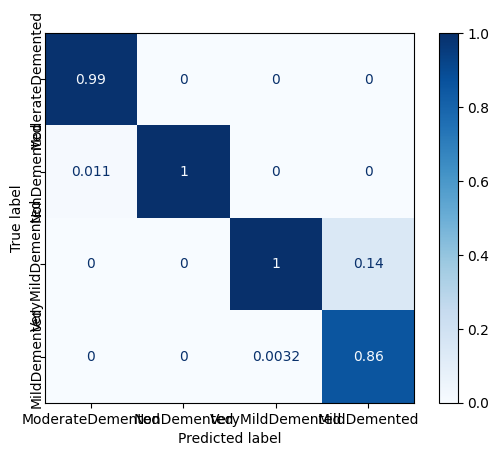

<Figure size 500x500 with 0 Axes>

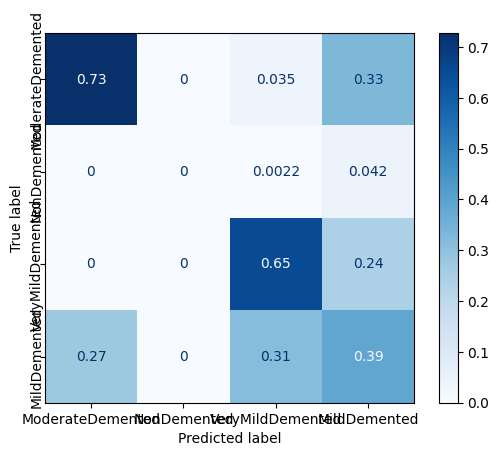

In [24]:
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')
print(class_names)
train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, class_names, False)
print(class_names)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [25]:
!zip -0 -r custom.zip ./*

  adding: custom_da_.keras (stored 0%)
  adding: custom_scratch_.keras (stored 0%)
  adding: images/ (stored 0%)
  adding: images/custom__scratch__accuracy_graph.pdf (stored 0%)
  adding: images/misclassified/ (stored 0%)
  adding: images/misclassified/custom__scratch__misclassified_3.pdf (stored 0%)
  adding: images/misclassified/custom__da__DA_misclassified_1.pdf (stored 0%)
  adding: images/misclassified/custom__scratch__misclassified_1.pdf (stored 0%)
  adding: images/misclassified/custom__da__DA_misclassified_2.pdf (stored 0%)
  adding: images/misclassified/custom__da__DA_misclassified_3.pdf (stored 0%)
  adding: images/misclassified/custom__scratch__misclassified_2.pdf (stored 0%)
  adding: images/custom__scratch__cm.pdf (stored 0%)
  adding: images/custom__da__DA_accuracy_graph.pdf (stored 0%)
  adding: images/custom__da__DA_loss_graph.pdf (stored 0%)
  adding: images/custom__scratch__loss_graph.pdf (stored 0%)
  adding: images/custom__da__DA_cm.pdf (stored 0%)
  adding: images/